In [1]:
import pandas as pd
import sqlite3
from pyspark.sql import SparkSession

import os # setting variable paths

# Anomaly detection
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.environ['PYSPARK_PYTHON'] = r"C:\Users\chaha\MiniConda3\python"
os.environ['PYSPARK_DRIVER_PYTHON'] = r"C:\Users\chaha\MiniConda3\python"
os.environ['JAVA_HOME'] = r"C:\Program Files\Java\jdk-17"

In [3]:
# Initialize Spark session
jdbc_driver_jar = "jars\sqlite-jdbc-3.46.0.0.jar" # provide path to be able to interact with SQLite db [[find out why Java is needed here]]

spark = SparkSession.builder \
    .appName("DAP_app") \
    .config("spark.driver.extraClassPath", jdbc_driver_jar) \
    .getOrCreate()

In [4]:
# Connect to the database
conn = sqlite3.connect('DAP_database.db')

# List all tables in db
tables_query = """SELECT name 
                  FROM sqlite_master 
                  WHERE type='table';"""

tables = pd.read_sql_query(tables_query, conn)

tables

,name
0,customer_information
1,purchase_order


### Invoke SQLite DB and Read Tables

In [5]:
# JDBC [Java Database Connectivity] URL for SQLite
jdbc_url = "jdbc:sqlite:DAP_database.db"

# Invoke tables from SQLite db
customer_info_spark_df = spark.read.format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "customer_information") \
    .load()

purchase_orders_spark_df = spark.read.format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "purchase_order") \
    .load()

In [6]:
customer_info_spark_df.show(5)
purchase_orders_spark_df.show(5)

+-----+----------+--------------------+----------------+--------------------+--------------------+
|index|Unnamed: 0|         customer_id|            name|               email|        phone_number|
+-----+----------+--------------------+----------------+--------------------+--------------------+
|    0|         0|69d07905-542b-4c8...|Dr. Shawn Sutton|ralvarado@example...|       (268)739-8688|
|    1|         1|8acff1f2-b02a-4bf...|    Gavin Garcia|whitney07@example...|001-702-203-6708x482|
|    2|         2|cbfa554e-ac86-430...|Kimberly Cabrera|abigail44@example...|     +1-368-641-3129|
|    3|         3|fd1318a8-ea43-43b...|   Rachel Garcia|sherryhernandez@e...| +1-742-448-9325x648|
|    4|         4|875d53d2-e3b0-431...|    Danielle Day|bailey67@example.com|001-900-207-8165x...|
+-----+----------+--------------------+----------------+--------------------+--------------------+
only showing top 5 rows

+-----+----------+--------------------+--------------------+----------+--------+----

In [7]:
# Minor manipulation and processing 
purchase_orders_spark_df = purchase_orders_spark_df.dropna()

In [8]:
total_quantity_per_customer_spark = purchase_orders_spark_df.groupBy('customer_id').sum('quantity')
total_quantity_per_customer_spark.show(5)

+--------------------+-------------+
|         customer_id|sum(quantity)|
+--------------------+-------------+
|515adcfe-d3f7-4e3...|           27|
|84593e79-62d8-4ad...|           46|
|b64a6e4a-2778-463...|           55|
|3fbf24c6-850f-405...|           52|
|bdff809b-eb91-4f3...|           16|
+--------------------+-------------+
only showing top 5 rows



### Anomaly Detection

In [9]:
# Prepare data for clustering
assembler = VectorAssembler(inputCols=['quantity', 'cost'], outputCol='features')
purchase_orders_spark_df = assembler.transform(purchase_orders_spark_df)

In [10]:
# Train KMeans model
kmeans = KMeans(k=3, seed=1)
model = kmeans.fit(purchase_orders_spark_df)

In [11]:
# Predict anomalies
predictions = model.transform(purchase_orders_spark_df)

In [12]:
# Identify anomalies (cluster with the fewest points)
cluster_counts = predictions.groupBy('prediction').count().orderBy('count')
anomaly_cluster = cluster_counts.first()['prediction']
anomalies = predictions.filter(predictions['prediction'] == anomaly_cluster)

In [13]:
anomalies.show(1)

+-----+----------+--------------------+--------------------+----------+--------+------+----------+------------+----------+
|index|Unnamed: 0|            order_id|         customer_id|product_id|quantity|  cost|order_date|    features|prediction|
+-----+----------+--------------------+--------------------+----------+--------+------+----------+------------+----------+
|   10|        10|fa77011f-26d0-46f...|9681e1c1-caf0-4ce...|product_83|       1|486.57|2024-05-25|[1.0,486.57]|         1|
+-----+----------+--------------------+--------------------+----------+--------+------+----------+------------+----------+
only showing top 1 row



### Visualisation

In [14]:
# Convert anomalies to Pandas for viz
anomalies_pd = anomalies.toPandas()
purchase_order_pd = purchase_orders_spark_df.toPandas()

In [15]:
cust_id = '00496016-5229-4e2a-886e-5f7fa11761f9'

custid_anomalies = anomalies_pd[anomalies_pd['customer_id'] == cust_id].sort_values(by= 'order_date') 
custid_purchases = purchase_order_pd[purchase_order_pd['customer_id'] == cust_id].sort_values(by= 'order_date') 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


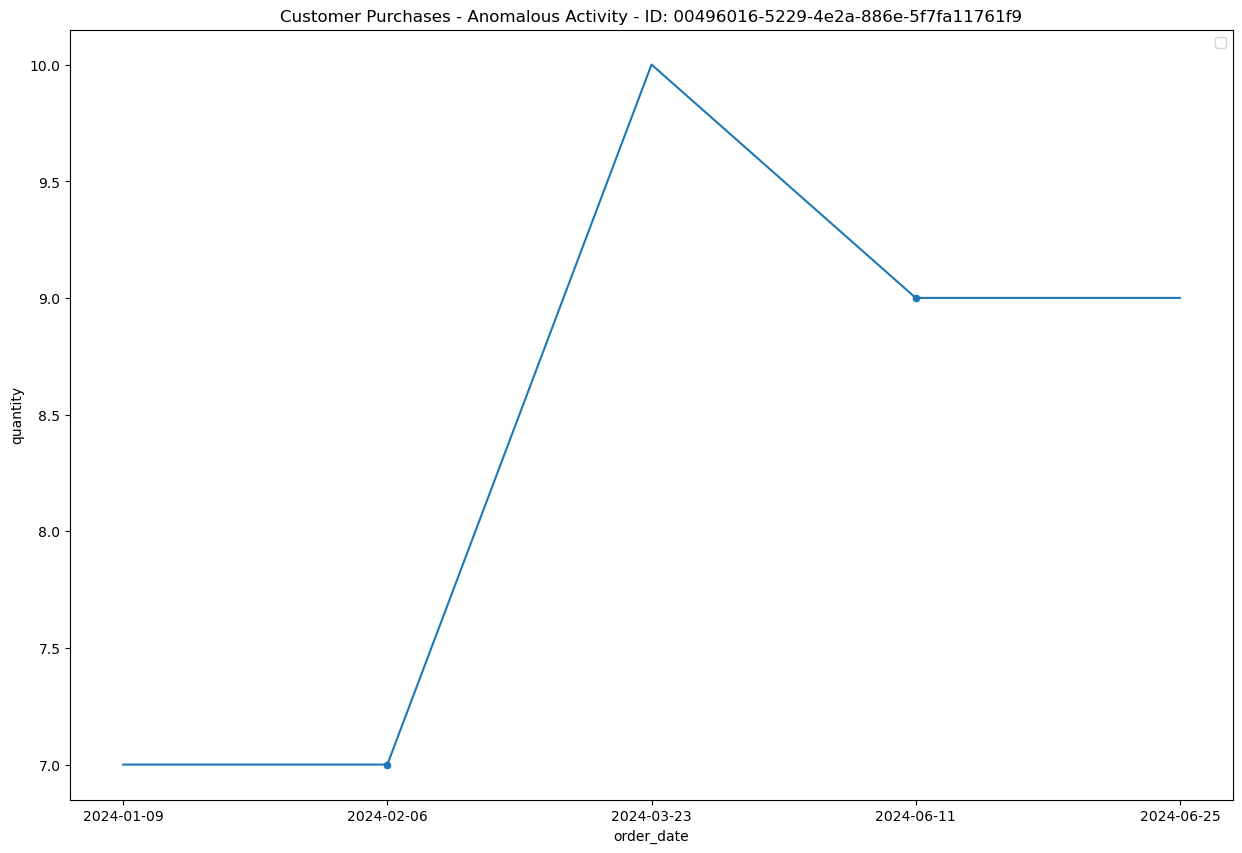

In [16]:
# Plotting the results
plt.figure(figsize=(15, 10))

# Purchases over time
sns.lineplot(data= custid_purchases, 
                x= 'order_date', 
                y= 'quantity',
            )

# Anomalous purchases over time
sns.scatterplot(data= custid_anomalies, 
                x= 'order_date', 
                y= 'quantity',
                markers= 'X')

plt.title(f'Customer Purchases - Anomalous Activity - ID: {cust_id}')
plt.legend()
plt.show()